In [1]:
from flight_schemas import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from delta import *
from pyspark.sql import Window

In [2]:
builder = SparkSession.builder.appName('flight_count_bp')
spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f9d82092-fae4-4430-8f98-93453c421c22;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.0.0 in central
	found io.delta#delta-storage;2.0.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 618ms :: artifacts dl 29ms
	:: modules in use:
	io.delta#delta-core_2.12;2.0.0 from central in [default]
	io.delta#delta-storage;2.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|ev

In [3]:
flight_data = spark.read.csv('hdfs://namenode:9000/csv/all-years.csv', schema=flightSchema)\
	.withColumn('FL_DATE', to_date(to_timestamp('FL_DATE', 'M/d/yyyy h:mm:ss a')))

In [ ]:
# For Testing upsert
flight_data = spark.read.csv('hdfs://namenode:9000/csv/2022.csv', schema=flightSchema)\
	.withColumn('FL_DATE', to_date(to_timestamp('FL_DATE', 'M/d/yyyy h:mm:ss a')))

In [4]:
# select relevant columns, dropping the rest
flight_data = flight_data.select( 'year'
                                , 'month'
                                , 'fl_date'
                                , 'op_unique_carrier'
                                , 'origin_airport_id'
                                , 'dest_airport_id'
                                , 'dep_delay_new'
                                , 'arr_delay_new'
                                , 'cancelled'
                                , 'diverted'
                                , 'air_time')

In [5]:
# clean dataset from useless columns
flight_data = flight_data.na.drop(subset=['year', 'origin_airport_id', 'dest_airport_id', 'fl_date'])
flight_data = flight_data.fillna({'arr_delay_new': 0.0})

In [6]:
# grab the fl_date of the flight with the highest delay for a given group
windowSpec = Window.partitionBy('year'
                            , 'month'
                            , 'op_unique_carrier'
                            , 'origin_airport_id'
                            , 'dest_airport_id').orderBy(col('arr_delay_new').desc())


In [7]:
arr_delay_dates = flight_data.withColumn('rank'
	                                    , rank().over(windowSpec)
                            ).filter(
                                col('rank') == 1
                            ).groupBy('year'
                                    , 'month'
                                    , 'op_unique_carrier'
                                    , 'origin_airport_id'
                                    , 'dest_airport_id'
                            ).agg(round(max('arr_delay_new'), 2).alias('max_arr_delay')
                                , first('fl_date').alias('max_arr_delay_fl_date')
                            )

In [8]:
# the rest of the groupby
flight_data = flight_data.groupBy('year'
                                , 'month'
                                , 'op_unique_carrier'
                                , 'origin_airport_id'
                                , 'dest_airport_id').agg( round(avg('arr_delay_new'), 2).alias('avg_arr_delay')
                                                        , round(percentile_approx('arr_delay_new', 0.5), 2).alias('med_arr_delay')
                                                        , round(avg(col('dep_delay_new') - col('arr_delay_new')), 2).alias('avg_time_recovered')
                                                        , sum('diverted').alias('nr_diverted')
                                                        , round(avg('air_time'), 2).alias('avg_airtime')
                                                        , count('*').alias('flight_count')
                                                        , sum('cancelled').alias('nr_cancelled'))


In [9]:
# join the highest delay with the res of the group
flight_data = arr_delay_dates.join( flight_data
                                , on=['year', 'month', 'op_unique_carrier', 'origin_airport_id', 'dest_airport_id']
                                , how='left')

In [10]:
# read the airports and airlines lookup tables
airports = spark.read.csv('hdfs://namenode:9000/lookup_tables/airport_id.csv', schema=numIdSchema)
carriers = spark.read.csv('hdfs://namenode:9000/lookup_tables/unique_carrier.csv', schema=StringIdSchema)

In [11]:
flight_data = flight_data.join(carriers.select('id', col('val').alias('airline'))
                            , flight_data['op_unique_carrier'] == carriers['id']
                            , how="left"
                        )

flight_data = flight_data.join(airports.select('id', col('val').alias('origin_airport'))
                            , flight_data['origin_airport_id'] == airports['id']
                            , how="left"
                        )

airports_alias = airports.alias('airports_alias')
flight_data = flight_data.join(airports_alias.select('id', col('val').alias('dest_airport'))
                            , flight_data['dest_airport_id'] == airports_alias['id']
                            , how="left"
                        )

In [12]:
flight_data = flight_data.drop("id")

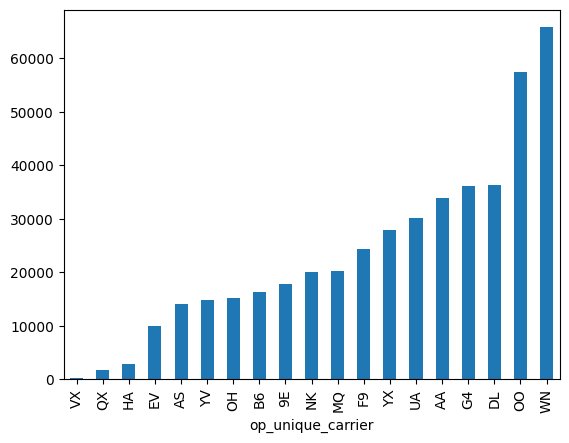

In [13]:
import matplotlib.pyplot as plt

# count unique values of 'name' column
unique_counts = flight_data.groupBy("op_unique_carrier").count().orderBy("count", ascending=True)

# convert to pandas dataframe and plot
unique_counts_pd = unique_counts.toPandas()
unique_counts_pd.plot(kind='bar', x='op_unique_carrier', y='count', legend=False)
plt.show()

In [ ]:
flight_data.show(10)

In [ ]:
# Checking if Table exists
if DeltaTable.isDeltaTable(spark, "hdfs://namenode:9000/spark-warehouse/sample_flight_table"):
    # Perform the upsert operation
    deltaDF = DeltaTable.forPath(spark, "hdfs://namenode:9000/spark-warehouse/sample_flight_table")
    merge_condition = "existing.year = upsert.year \
                    AND existing.month = upsert.month \
                    AND existing.op_unique_carrier = upsert.op_unique_carrier \
                    AND existing.origin_airport_id = upsert.origin_airport_id \
                    AND existing.dest_airport_id = upsert.dest_airport_id "

    deltaDF.alias('existing') \
        .merge(flight_data.alias('upsert'), merge_condition) \
        .whenMatchedUpdateAll() \
        .whenNotMatchedInsertAll() \
        .execute()  
else:
    # Create new delta table
    flight_data.write.format("delta").mode("overwrite").saveAsTable("sample_flight_table")

In [ ]:
# Just for testing
deltaDF.toDF().count()

In [ ]:
#445659

In [ ]:
spark.stop()